# Levenberg-Marquardt Optimization with AADC Derivatives

This notebook demonstrates using Levenberg-Marquardt optimization with both SciPy and the AADC implementation.

## 1. Standard Implementation with SciPy

First, let's import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares

import aadc
import aadc.ndarray
from aadc.scipy.interpolate import CubicSpline

%matplotlib inline
plt.ioff()  # Turn off interactive mode

Now we'll define our residual function:

In [2]:
# Define the function to be minimized (residuals)
def residual_func(params, x_data, y_data):
    # Example: fitting y = a * exp(-b * x) + c
    a, b, c = params
    y_model = a * np.exp(-b * x_data) + c
    return y_model - y_data

Let's generate some sample data for our optimization problem:

In [3]:
# Generate some sample data
np.random.seed(42)  # For reproducibility
x_data = np.linspace(0, 10, 10)
true_params = [5.0, 0.5, 1.0]
y_true = true_params[0] * np.exp(-true_params[1] * x_data) + true_params[2]
noise = np.random.normal(0, 0.2, x_data.shape)
y_data = y_true + noise

print("x_data:", x_data)
print("y_data:", y_data)

# Define data for spline fitting
spline_x_data = np.linspace(0, 10, 5)
initial_params = np.ones(np.shape(spline_x_data))

def spline_residual_func(params, x_data, y_data):
    spline = CubicSpline(spline_x_data, aadc.ndarray.AADCArray(params))
    return spline(x_data) - y_data

x_data: [ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.        ]
y_data: [6.09934283 3.84111424 2.77550265 2.24898399 1.49500944 1.26405523
 1.49421253 1.25582732 0.96482327 1.14220174]


Now we'll create an optimization function:

True parameters: [5.0, 0.5, 1.0]
Optimal parameters: [6.03671846 2.50987112 1.53955228 1.21103624 1.0872736 ]
Cost: 0.10861489856501244
Success: True


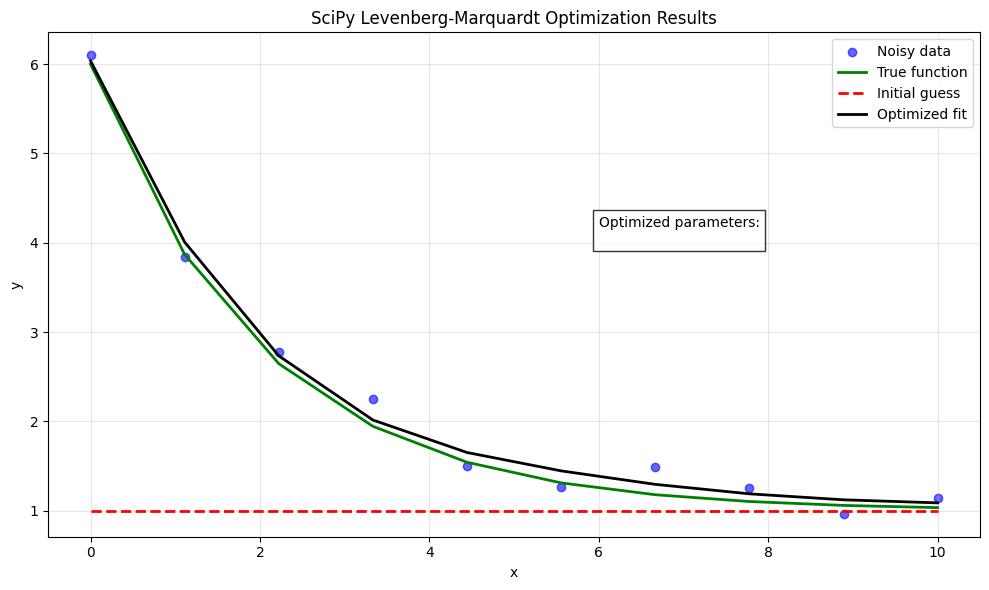

In [4]:
def run_optimization(x_data, y_data):
    # Perform Levenberg-Marquardt optimization
    result = least_squares(
        spline_residual_func,
        initial_params,
        method='lm',
        args=(x_data, y_data),
        verbose=0
    )

    return result, initial_params

# Run the optimization
result, initial_params = run_optimization(x_data, y_data)

# Print results
print("True parameters:", true_params)
print("Optimal parameters:", result.x)
print("Cost:", result.cost)
print("Success:", result.success)

# Plot the optimization results for SciPy implementation
plt.figure(figsize=(10, 6))

# Plot the noisy data points
plt.scatter(x_data, y_data, color='blue', alpha=0.6, label='Noisy data')

# Plot the true function
plt.plot(x_data, y_true, 'g-', linewidth=2, label='True function')

# Plot the initial guess
plt.plot(spline_x_data, initial_params, 'r--', linewidth=2, label='Initial guess')

# Plot the optimized function
fitted_spline = CubicSpline(spline_x_data, result.x)
y_opt = fitted_spline(x_data)
plt.plot(x_data, y_opt, 'k-', linewidth=2, label='Optimized fit')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('SciPy Levenberg-Marquardt Optimization Results')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box with optimized parameters
param_text = 'Optimized parameters:\n'
plt.text(6, 4, param_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 2. Implementation with AADC

Note that objective function is using y_data internally and derivatives must be calculated with respect to y_data.
AADC.least_squares() function doesn't require Jacobian w.r.t. y_data, it will be calculated automatically. See Automatic IFT publication for more details.

In [5]:
# AADC version

func = aadc.Kernel()
func.start_recording()

# Define the residual function with AADC inputs
iy_data = aadc.ndarray.AADCArray([aadc.idouble(y) for y in y_data])
iy_data_arg = [y.mark_as_input() for y in iy_data]

def objective(params):
    return spline_residual_func(params, x_data, iy_data)

initial_params = aadc.ndarray.AADCArray([aadc.idouble(y) for y in initial_params])
aadc_result = aadc.least_squares(objective, initial_params)

print("AADC Optimal parameters:", aadc_result.x)

x_res = [a.mark_as_output() for a in aadc_result.x]

func.stop_recording()

func.print_passive_extract_locations()

inputs = {y_arg: y for y_arg, y in zip(iy_data_arg, y_data)}
request = {x_res[i]: iy_data_arg for i in range(len(x_res))}

res = aadc.evaluate(func, request, inputs)

print("True parameters:", true_params)
print("Scipy Optimal parameters:", result.x)
print("AADC Kernel Optimal parameters:", [res[0][x_res[i]] for i in range(len(x_res))])

AADC Optimal parameters: [idouble([AAD[rv] [adj] :38,6.04e+00]), idouble([AAD[rv] [adj] :39,2.51e+00]), idouble([AAD[rv] [adj] :40,1.54e+00]), idouble([AAD[rv] [adj] :41,1.21e+00]), idouble([AAD[rv] [adj] :42,1.09e+00])]
True parameters: [5.0, 0.5, 1.0]
Scipy Optimal parameters: [6.03671846 2.50987112 1.53955228 1.21103624 1.0872736 ]
AADC Kernel Optimal parameters: [array([6.03671846]), array([2.50987112]), array([1.53955228]), array([1.21103624]), array([1.08727361])]
Number active to passive conversions: 0 while recording Python


## 3. Comparing Derivatives

Let's compare the derivatives computed by both methods:

In [6]:
print("AADC Kernel Derivatives param 0:", res[1][x_res[0]])
print("AADC Kernel Derivatives param 1:", res[1][x_res[1]])
print("AADC Kernel Derivatives param 2:", res[1][x_res[2]])

AADC Kernel Derivatives param 0: {Arg(6): array([0.92787611]), Arg(7): array([0.19498474]), Arg(8): array([-0.09279182]), Arg(9): array([-0.10036397]), Arg(10): array([0.00735788]), Arg(11): array([0.07029494]), Arg(12): array([0.03949617]), Arg(13): array([-0.02286175]), Arg(14): array([-0.04977051]), Arg(15): array([0.0257782])}
AADC Kernel Derivatives param 1: {Arg(6): array([-0.1145122]), Arg(7): array([0.3308886]), Arg(8): array([0.42277629]), Arg(9): array([0.30197291]), Arg(10): array([0.10930054]), Arg(11): array([-0.01854037]), Arg(12): array([-0.03964641]), Arg(13): array([-0.00691121]), Arg(14): array([0.02264997]), Arg(15): array([-0.00797811])}
AADC Kernel Derivatives param 2: {Arg(6): array([0.05291954]), Arg(7): array([-0.12207664]), Arg(8): array([-0.02032806]), Arg(9): array([0.20174858]), Arg(10): array([0.38773657]), Arg(11): array([0.38773657]), Arg(12): array([0.20174858]), Arg(13): array([-0.02032806]), Arg(14): array([-0.12207664]), Arg(15): array([0.05291954])}


Now let's verify the derivatives using the finite difference method:

In [7]:
# Define the function to calculate derivatives using finite differences
def calculate_finite_diff_derivatives(params, x_data, y_data, epsilon=1e-6):
    derivatives = []

    for i in range(len(params)):
        param_derivatives = []

        for j in range(len(y_data)):
            # Create modified y_data with a bump in one element
            y_bumped = y_data.copy()
            y_bumped[j] += epsilon

            # Run optimization with bumped data
            bumped_result, _ = run_optimization(x_data, y_bumped)

            # Calculate derivative (change in parameter / change in y)
            derivative = (bumped_result.x[i] - params[i]) / epsilon
            param_derivatives.append(derivative)

        derivatives.append(param_derivatives)

    return derivatives

# Calculate finite difference derivatives for all parameters
print("Calculating finite difference derivatives (this may take some time)...")
fd_derivatives = calculate_finite_diff_derivatives(result.x, x_data, y_data)

# Extract AADC derivatives in a format suitable for comparison
aadc_derivatives = []
for i in range(len(result.x)):
    # Extract derivatives from the AADC result
    aadc_deriv_i = np.array([res[1][x_res[i]][y_arg][0] for y_arg in iy_data_arg])
    aadc_derivatives.append(aadc_deriv_i)

    print(f"Parameter {i} derivatives:")
    print(f"  AADC:            {aadc_deriv_i}")
    print(f"  Finite diff:     {fd_derivatives[i]}")
    print(f"  Mean difference: {np.mean(np.abs(aadc_deriv_i - np.array(fd_derivatives[i])))}")
    print()

Calculating finite difference derivatives (this may take some time)...
Parameter 0 derivatives:
  AADC:            [ 0.92787611  0.19498474 -0.09279182 -0.10036397  0.00735788  0.07029494
  0.03949617 -0.02286175 -0.04977051  0.0257782 ]
  Finite diff:     [0.9307555037807447, 0.19671257156517186, -0.08973135923184827, -0.09889285657038727, 0.00783987896824101, 0.07310626415346633, 0.04223257832336458, -0.024106295626324936, -0.05005474612573835, 0.025560999539209206]
  Mean difference: 0.0016914523683307504

Parameter 1 derivatives:
  AADC:            [-0.1145122   0.3308886   0.42277629  0.30197291  0.10930054 -0.01854037
 -0.03964641 -0.00691121  0.02264997 -0.00797811]
  Finite diff:     [-0.11604862004688243, 0.3328495359333772, 0.4237462913891932, 0.30088632829716744, 0.1111370502293596, -0.017011283492962548, -0.03876494902854688, -0.005572273309439879, 0.02156855316570727, -0.008754791114284899]
  Mean difference: 0.0012998024812665306

Parameter 2 derivatives:
  AADC:         

## 4. Combined Visualization

Let's visualize both the optimization results and parameter sensitivities in a single figure:

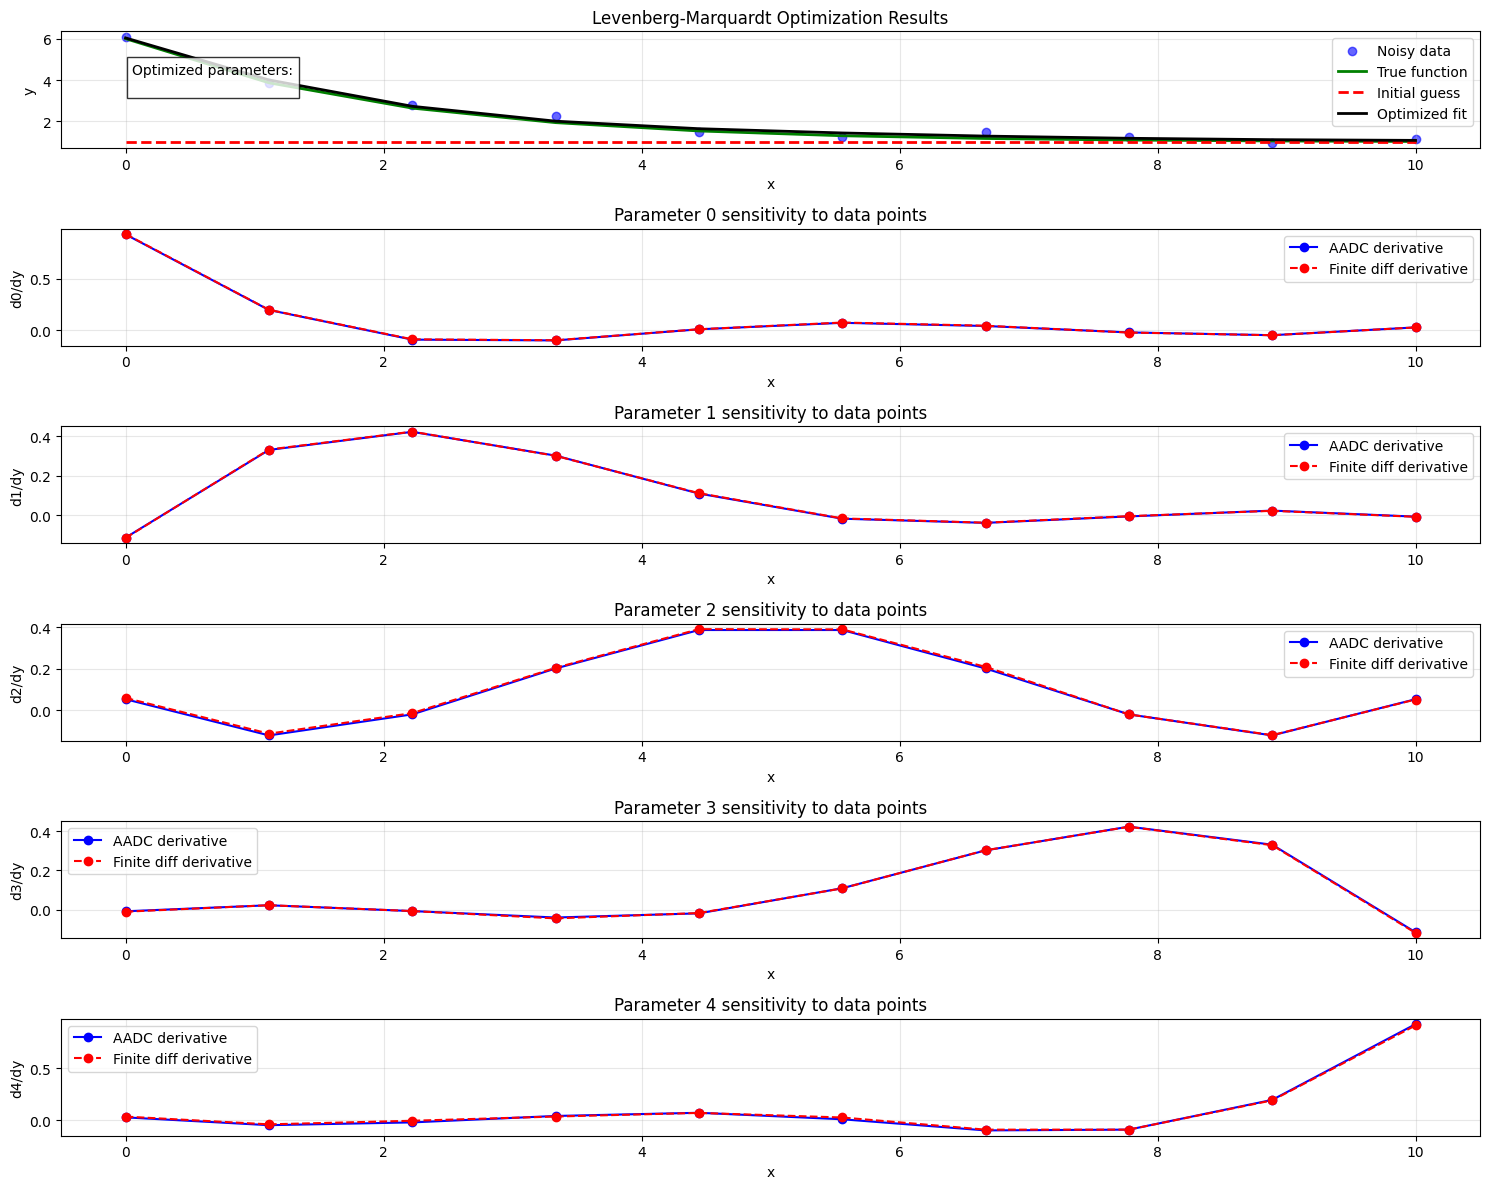

In [8]:
# Create a combined figure with optimization results and parameter sensitivities
fig = plt.figure(figsize=(15, 12))

# Plot 1: Optimization Results (Top)
ax1 = plt.subplot2grid((initial_params.size+1, 1), (0, 0), rowspan=1)

# Plot the noisy data points
ax1.scatter(x_data, y_data, color='blue', alpha=0.6, label='Noisy data')

# Plot the true function
ax1.plot(x_data, y_true, 'g-', linewidth=2, label='True function')

# Plot the initial guess
fitted_spline = CubicSpline(spline_x_data, initial_params)
initial_guess = fitted_spline(x_data)
ax1.plot(x_data, initial_guess, 'r--', linewidth=2, label='Initial guess')

# Plot the optimized function
fitted_spline = CubicSpline(spline_x_data, result.x)
y_opt = fitted_spline(x_data)
ax1.plot(x_data, y_opt, 'k-', linewidth=2, label='Optimized fit')

# Add labels and legend
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Levenberg-Marquardt Optimization Results')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Add text box with optimized parameters
param_text = 'Optimized parameters:\n'
ax1.text(0.05, 0.5, param_text, transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Plots 2-4: Parameter Sensitivities (Bottom rows)
for i in range(len(result.x)):
    ax = plt.subplot2grid((initial_params.size+1, 1), (i+1, 0), rowspan=1)

    ax.plot(x_data, aadc_derivatives[i], 'bo-', label='AADC derivative')
    ax.plot(x_data, fd_derivatives[i], 'ro--', label='Finite diff derivative')

    ax.set_title(f'Parameter {i} sensitivity to data points')
    ax.set_xlabel('x')
    ax.set_ylabel(f'd{i}/dy')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


# Automatic Implicit Function Theorem - Summary

## Paper Details
- **Title**: Automatic Implicit Function Theorem
- **Authors**: Dmitri Goloubentsev, Evgeny Lakshtanov, Vladimir Piterbarg
- **Affiliation**: Matlogica, Universidade de Aveiro, NatWest Markets, Imperial College London
- **Published**: December 14, 2021 (Revised: May 31, 2022)
- **SSRN ID**: 3984964
- **URL**: [https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3984964](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3984964)